In [20]:
# materials/stack

import pickle
import numpy as np
np.float_ = np.float64
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from IPython.display import display
import matplotlib.pyplot as plt

data = pd.read_parquet('data/raw/data_v1.parquet')

In [21]:
# Running MAUs model

# Função para carregar o modelo Prophet
def load_prophet_model(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

# Função para gerar previsões
def make_forecast(model, periods, frequency):
    future = model.make_future_dataframe(periods=periods, freq=frequency)
    return model.predict(future)

# Caminhos dos modelos
models = {
    'ig': 'models/ig_maus_prophet_model_v1',
    'tk': 'models/tk_maus_prophet_model_v1'
}

# Carregar modelos
ig_model = load_prophet_model(models['ig'])
tk_model = load_prophet_model(models['tk'])

# Fazer previsões
ig_maus_forecast = make_forecast(ig_model, periods=4, frequency='QE')
tk_maus_forecast = make_forecast(tk_model, periods=4, frequency='QE')

In [22]:
# modelagem
ig_y = np.array(data['ig_revenue'].values).reshape(-1, 1)
ig_X = np.array(data['ig_maus'].values).reshape(-1, 1) 

tk_y = np.array(data['tk_revenue'].values).reshape(-1, 1)
tk_X = np.array(data['tk_maus'].values).reshape(-1, 1)  

ig_new_X = np.array(ig_maus_forecast['yhat'].tail(4).values).reshape(-1, 1)
tk_new_X = np.array(tk_maus_forecast['yhat'].tail(4).values).reshape(-1, 1)

ig_model = LinearRegression().fit(ig_X, ig_y)
tk_model = LinearRegression().fit(tk_X, tk_y)

ig_y_pred = ig_model.predict(ig_new_X)
tk_y_pred = tk_model.predict(tk_new_X)

In [23]:
# Criação do DataFrame vazio
forecast = pd.DataFrame()

# Adicionando a coluna 'quarter' com os últimos 4 valores de 'ds' de ig_maus_forecast
forecast['quarter'] = ig_maus_forecast['ds'].tail(4)
forecast['quarter_label'] = ['Q2 2024', 'Q3 2024', 'Q4 2024', 'Q1 2025']

# ig
forecast['ig_maus'] = ig_new_X.round(0).astype(int)
forecast['ig_revenue'] = ig_y_pred.round(0).astype(int)

# tk
forecast['tk_maus'] = tk_new_X.round(0).astype(int)
forecast['tk_revenue'] = tk_y_pred.round(0).astype(int)

In [24]:
# original data and forecast
display(data.tail(4))
display(forecast)

,quarter,quarter_label,ig_maus,ig_revenue,tk_maus,tk_revenue
17,2023-04-01,Q2 2023,2115000000,11775000000,1587000000,3667000000
18,2023-07-01,Q3 2023,2145000000,12736000000,1616000000,4241000000
19,2023-10-01,Q4 2023,2180000000,15322000000,1635000000,4997000000
20,2024-01-01,Q1 2024,2231000000,14472000000,1666000000,4583000000


,quarter,quarter_label,ig_maus,ig_revenue,tk_maus,tk_revenue
21,2024-03-31,Q2 2024,2221735781,12735807893,1871336709,4527462823
22,2024-06-30,Q3 2024,2242448858,12929389484,1631989456,3749413402
23,2024-09-30,Q4 2024,2276922459,13251575055,1576689951,3569650540
24,2024-12-31,Q1 2025,2369122780,14113266663,1495697320,3306366674


In [25]:
data

,quarter,quarter_label,ig_maus,ig_revenue,tk_maus,tk_revenue
0,2019-01-01,Q1 2019,1160000000,3255000000,333000000,56000000
1,2019-04-01,Q2 2019,1210000000,3887000000,381000000,65000000
2,2019-07-01,Q3 2019,1255000000,4066000000,439000000,82000000
3,2019-10-01,Q4 2019,1300000000,5016000000,508000000,167000000
4,2020-01-01,Q1 2020,1365000000,4475000000,583000000,347000000
5,2020-04-01,Q2 2020,1435000000,4888000000,700000000,638000000
6,2020-07-01,Q3 2020,1490000000,5399000000,667000000,778000000
7,2020-10-01,Q4 2020,1555000000,7075000000,756000000,883000000
8,2021-01-01,Q1 2021,1630000000,6830000000,812000000,829000000
9,2021-04-01,Q2 2021,1690000000,7792000000,902000000,1114000000


In [26]:
data.dtypes

quarter          datetime64[ns]
quarter_label            object
ig_maus                   int64
ig_revenue                int64
tk_maus                   int64
tk_revenue                int64
dtype: object

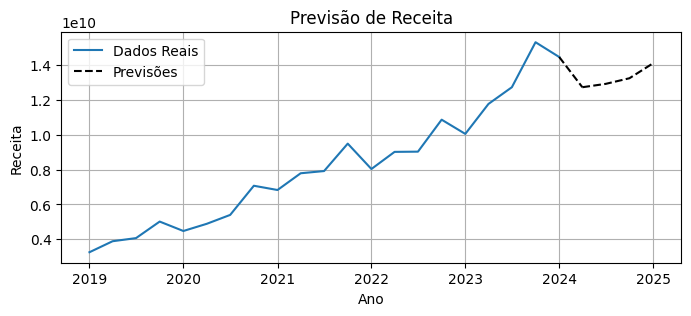

In [27]:
# Plotar os dados reais
plt.figure(figsize=(8, 3))
plt.plot(data['quarter'], data['ig_revenue'], label='Dados Reais')

# Plotar as previsões, começando do último ponto dos dados reais
plt.plot(forecast['quarter'], forecast['ig_revenue'], label='Previsões', linestyle='--', color='black')

# Adicionar um ponto de conexão entre os dados reais e as previsões
plt.plot([data['quarter'].iloc[-1], forecast['quarter'].iloc[0]], 
         [data['ig_revenue'].iloc[-1], forecast['ig_revenue'].iloc[0]], 
         linestyle='--', color='black')

# Adicionar legendas e rótulos
plt.legend()
plt.xlabel('Ano')
plt.ylabel('Receita')
plt.title('Previsão de Receita')
plt.grid(True)

# Mostrar o gráfico
plt.show()

In [28]:
# export forecast
forecast.to_parquet('data/processed/data_v1_forecast.parquet', index=False)